In [1]:
# here i need to load all the test data
import pandas as pd
test=pd.read_csv('/home/saiteja_kandra/data/churn_comp_refresh/sample_submission_v2.csv')

### Firstly here data is spread in multiple tables so i merged all the test data and prepared the X_test and then passed to function

### Here as suggested in the email chain and classroom i have created two functions with only one best model that was observed i.e; neural net  model

###  function1 is used for whole complete test data and computed the accuracy metric

###  function2 is just written for single point(1*d) and the predicted the class label



In [2]:
#count number of transactions per user
transactions_data=pd.read_csv('/home/saiteja_kandra/data/churn_comp_refresh/transactions_v2.csv')

In [3]:
transaction_count_per_user = transactions_data.groupby('msno')['msno'].count()
transaction_count_df = pd.DataFrame(transaction_count_per_user)
transaction_count_df.columns =['transaction_count'] #adding the column
transaction_count_df.reset_index(inplace=True) # this will set the index properly
transactions_data= transaction_count_df.merge(transactions_data,on='msno')

In [4]:
# merging test labels with transactions dataframe
test = test.merge(transactions_data,how='left',on='msno')

In [5]:
import pandas as pd
members_v3=pd.read_csv('/home/saiteja_kandra/members_v3.csv')

In [6]:
test=test.merge(members_v3,how='left',on='msno')

In [7]:
logs_data = pd.read_csv('/home/saiteja_kandra/data/churn_comp_refresh/user_logs_v2.csv')

In [8]:
#taking sum of each user and on each feature
user_logs_sum = logs_data.groupby('msno',as_index=False).sum()
user_logs_sum.drop(columns=['date'],axis=1,inplace=True)

In [9]:
#taking mean of each user and on each feature
user_logs_mean = logs_data.groupby('msno',as_index=False).mean()
user_logs_mean.drop(columns=['date'],axis=1,inplace=True)

In [10]:
user_logs_mean.columns=['msno','mean_num_25','mean_num_50','mean_num_75','mean_num_985','mean_num_100','mean_num_unq','mean_total_min']

In [11]:
final_logs_data = user_logs_mean.merge(user_logs_sum, on='msno')


In [16]:
test_points= test.merge(final_logs_data, how='left',on='msno')

In [17]:
test_points.head()

,msno,is_churn,transaction_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,...,mean_num_100,mean_num_unq,mean_total_min,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,1.0,41.0,30.0,99.0,99.0,1.0,20170318.0,20170418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,1.0,34.0,30.0,149.0,149.0,1.0,20170331.0,20170430.0,...,54.870968,73.322581,16154.923871,550.0,176.0,125.0,131.0,1701.0,2273.0,500802.64
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,1.0,41.0,30.0,99.0,99.0,1.0,20170315.0,20170415.0,...,8.400000,14.900000,2381.427000,79.0,19.0,1.0,2.0,84.0,149.0,23814.27
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,1.0,41.0,30.0,99.0,99.0,1.0,20170327.0,20170427.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,1.0,30.0,30.0,129.0,129.0,1.0,20170322.0,20170421.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
import numpy as np
from datetime import datetime
import numpy as np
import joblib 
from keras.models import model_from_json
import tensorflow
from sklearn.metrics import accuracy_score, log_loss

Using TensorFlow backend.


In [113]:
y_true = test_points['is_churn']

In [38]:

def function1(final_test,ytest_ohe):
    
    
    ''' preprocess the missing values filling with median and mode values '''
    
    final_test=final_test.drop(['gender'],axis=1)
    
    final_test['total_minutes'] =final_test['total_secs']/60
    
    final_test.drop(columns=['total_secs'],inplace=True)
    
    # taking features names to fill missing values with median and mode
    numerical_columns = ['payment_plan_days','plan_list_price','num_25', 
                     'num_50', 'num_75', 'num_985', 'num_100','num_unq', 
                     'total_minutes', 'mean_num_25','mean_num_50','mean_num_75',
                     'mean_num_985','mean_num_100','mean_num_unq', 'mean_total_min','bd','transaction_count','actual_amount_paid']
    
    categorical_columns =['payment_method_id','is_auto_renew','city',
                      'registered_via','transaction_date','registration_init_time','is_cancel','membership_expire_date']
    
    median_data= pd.read_pickle('/home/saiteja_kandra/median_data.pkl')
    
    mode_data =pd.read_pickle('/home/saiteja_kandra/mode_data.pkl')
                   
    #fill the missing values
    for column in numerical_columns:
        final_test[column].fillna(median_data[column],inplace=True)
    for column in categorical_columns:
        final_test[column].fillna(mode_data[column],inplace=True)
        
   

    final_test['day_of_month']=final_test.transaction_date.apply(lambda x:
                        np.int8(str(int(x))[6:]))

    final_test['transaction_month'] =final_test.transaction_date.apply(lambda x: np.int8(str(int(x))[4:6]))

    final_test['dayofweek'] =final_test.transaction_date.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").isoweekday())

    final_test['trans_is_weekend'] = final_test.dayofweek.map(lambda x:1 if x in (6,7) else 0)
    final_test['trans_month_day'] = final_test.transaction_date.apply(lambda x: np.int16(str(int(x))[4:]))

    final_test['registration_day']=final_test.registration_init_time.apply(lambda x: np.int8(str(int(x))[6:] ))
    final_test['registration_month']=final_test.registration_init_time.apply(lambda x: np.int8(str(int(x))[4:6]))
    final_test['registration_day_month']=final_test.registration_init_time.apply(lambda x: np.int16(str(int(x))[4:]))
    final_test['registration_day_num'] =final_test.registration_init_time.apply(lambda x:datetime.strptime(str(int(x)), "%Y%m%d").isoweekday())
    final_test['registration_weekend']=final_test.registration_day_num.map(lambda x: 1 if x in (6,7) else 0)
    final_test['price_per_day'] = final_test['plan_list_price']/final_test['payment_plan_days']

    #creating ratio features i.e number of songs that are 25% of their length  out of total number of songs listened
    # creating a feature 'total_num' i.e. total number of songs listened by the user
    final_test['min_per_song'] = final_test['total_minutes']/(final_test['num_25']+final_test['num_50']+final_test['num_75']+final_test['num_985']+final_test['num_100'])
    final_test['total_num'] = final_test['num_25']+final_test['num_50']+final_test['num_75']+final_test['num_985']+final_test['num_100']
    final_test['num_25_ratio'] = final_test['num_25']/final_test['total_num']
    final_test['num_50_ratio'] = final_test['num_50']/final_test['total_num']
    final_test['num_75_ratio'] = final_test['num_75']/final_test['total_num']
    final_test['num_985_ratio'] =final_test['num_985']/final_test['total_num']
    final_test['num_100_ratio'] =final_test['num_100']/final_test['total_num']
    final_test['avg_min_per_unq'] = final_test['mean_total_min']/final_test['mean_num_unq']
    final_test['total_by_unq'] = final_test['total_num']/final_test['num_unq']
    
    
    final_test = final_test.drop(columns=['msno','is_churn','transaction_date','registration_init_time'],axis=1)

    # Load the model from the file 
    lgb1_from_joblib = joblib.load('lgb1.pkl')  

    # log-loss on test dataset
    yte_pred_prob1 = lgb1_from_joblib.predict_proba(final_test)
   
    # Load the model from the file 
    lgb2_from_joblib = joblib.load('lgb2.pkl')  

    # log-loss on test dataset
    yte_pred_prob2 = lgb2_from_joblib.predict_proba(final_test)
  
    
        # Load the model from the file 
    lgb3_from_joblib = joblib.load('lgb3.pkl')  

    # log-loss on test dataset
    yte_pred_prob3 = lgb3_from_joblib.predict_proba(final_test)
 
 
    
    pred_test = np.hstack([yte_pred_prob1,
                       yte_pred_prob2,
                       yte_pred_prob3])
    
   
      # load json and create model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    opt = tensorflow.keras.optimizers.Adam(0.0001)
    loaded_model.compile(optimizer=opt,loss='binary_crossentropy',
                 metrics=['accuracy'])
    test_pred_prob_nn = loaded_model.predict(pred_test)
    test_pred_nn = [np.argmax(test_pred_prob_nn[i]) for i in
                 range(pred_test.shape[0])]
    print("neural net accuracy",accuracy_score(test_pred_nn,ytest_ohe))
    # saving predicted probabilities in a csv file
    submission = pd.DataFrame()
    submission['msno'] = final_test['msno']
    submission['is_churn'] = test_pred_nn
    submission.to_csv("/home/saiteja_kandra/submission_test.csv",index=False)
   

In [40]:
function1(test_points,y_true)

neural net accuracy 0.9612946309028058


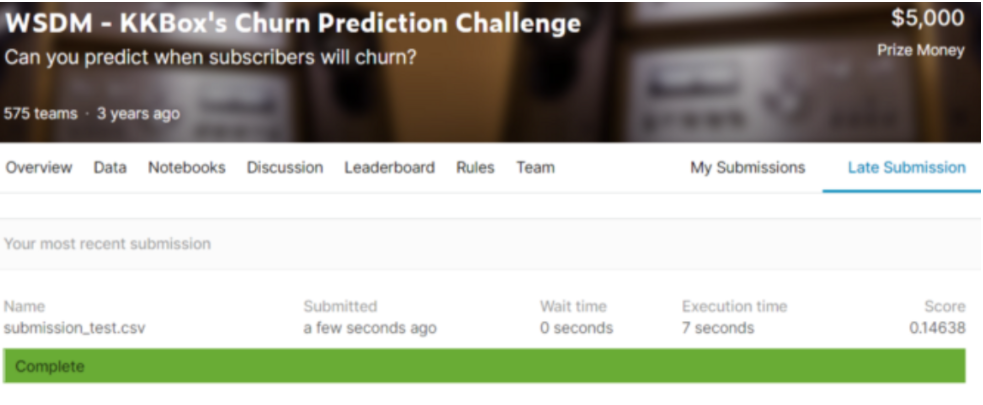

In [29]:
def function2(final_test):
    
    
    ''' preprocess the missing values filling with median and mode values '''
    
    final_test=final_test.drop(['gender'],axis=1)
    
    final_test['total_minutes'] =final_test['total_secs']/60
    
    final_test.drop(columns=['total_secs'],inplace=True)
    
    # taking features names to fill missing values with median and mode
    numerical_columns = ['payment_plan_days','plan_list_price','num_25', 
                     'num_50', 'num_75', 'num_985', 'num_100','num_unq', 
                     'total_minutes', 'mean_num_25','mean_num_50','mean_num_75',
                     'mean_num_985','mean_num_100','mean_num_unq', 'mean_total_min','bd','transaction_count','actual_amount_paid']
    
    categorical_columns =['payment_method_id','is_auto_renew','city',
                      'registered_via','transaction_date','registration_init_time','is_cancel','membership_expire_date']
    
    median_data= pd.read_pickle('/home/saiteja_kandra/median_data.pkl')
    
    mode_data =pd.read_pickle('/home/saiteja_kandra/mode_data.pkl')
                   
    #fill the missing values
    for column in numerical_columns:
        final_test[column].fillna(median_data[column],inplace=True)
    for column in categorical_columns:
        final_test[column].fillna(mode_data[column],inplace=True)
        
   

    final_test['day_of_month']=final_test.transaction_date.apply(lambda x:
                        np.int8(str(int(x))[6:]))

    final_test['transaction_month'] =final_test.transaction_date.apply(lambda x: np.int8(str(int(x))[4:6]))

    final_test['dayofweek'] =final_test.transaction_date.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").isoweekday())

    final_test['trans_is_weekend'] = final_test.dayofweek.map(lambda x:1 if x in (6,7) else 0)
    final_test['trans_month_day'] = final_test.transaction_date.apply(lambda x: np.int16(str(int(x))[4:]))

    final_test['registration_day']=final_test.registration_init_time.apply(lambda x: np.int8(str(int(x))[6:] ))
    final_test['registration_month']=final_test.registration_init_time.apply(lambda x: np.int8(str(int(x))[4:6]))
    final_test['registration_day_month']=final_test.registration_init_time.apply(lambda x: np.int16(str(int(x))[4:]))
    final_test['registration_day_num'] =final_test.registration_init_time.apply(lambda x:datetime.strptime(str(int(x)), "%Y%m%d").isoweekday())
    final_test['registration_weekend']=final_test.registration_day_num.map(lambda x: 1 if x in (6,7) else 0)
    final_test['price_per_day'] = final_test['plan_list_price']/final_test['payment_plan_days']

    #creating ratio features i.e number of songs that are 25% of their length  out of total number of songs listened
    # creating a feature 'total_num' i.e. total number of songs listened by the user
    final_test['min_per_song'] = final_test['total_minutes']/(final_test['num_25']+final_test['num_50']+final_test['num_75']+final_test['num_985']+final_test['num_100'])
    final_test['total_num'] = final_test['num_25']+final_test['num_50']+final_test['num_75']+final_test['num_985']+final_test['num_100']
    final_test['num_25_ratio'] = final_test['num_25']/final_test['total_num']
    final_test['num_50_ratio'] = final_test['num_50']/final_test['total_num']
    final_test['num_75_ratio'] = final_test['num_75']/final_test['total_num']
    final_test['num_985_ratio'] =final_test['num_985']/final_test['total_num']
    final_test['num_100_ratio'] =final_test['num_100']/final_test['total_num']
    final_test['avg_min_per_unq'] = final_test['mean_total_min']/final_test['mean_num_unq']
    final_test['total_by_unq'] = final_test['total_num']/final_test['num_unq']
    
    
    final_test = final_test.drop(columns=['msno','is_churn','transaction_date','registration_init_time'],axis=1)

    # Load the model from the file 
    lgb1_from_joblib = joblib.load('lgb1.pkl')  

    # log-loss on test dataset
    yte_pred_prob1 = lgb1_from_joblib.predict_proba(final_test)
   
    # Load the model from the file 
    lgb2_from_joblib = joblib.load('lgb2.pkl')  

    # log-loss on test dataset
    yte_pred_prob2 = lgb2_from_joblib.predict_proba(final_test)
  
    
        # Load the model from the file 
    lgb3_from_joblib = joblib.load('lgb3.pkl')  

    # log-loss on test dataset
    yte_pred_prob3 = lgb3_from_joblib.predict_proba(final_test)
 
 
    
    pred_test = np.hstack([yte_pred_prob1,
                       yte_pred_prob2,
                       yte_pred_prob3])
    
   
      # load json and create model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")
    opt = tensorflow.keras.optimizers.Adam(0.0001)
    loaded_model.compile(optimizer=opt,loss='binary_crossentropy',
                 metrics=['accuracy'])
    test_pred_prob_nn = loaded_model.predict(pred_test)
    test_pred_nn = [np.argmax(test_pred_prob_nn[i]) for i in
                 range(pred_test.shape[0])]
    print("test predicted value",test_pred_nn)
   

In [19]:
import pandas as pd
test=pd.read_csv('/home/saiteja_kandra/data/churn_comp_refresh/sample_submission_v2.csv')
single_test_point =test[:1]

In [20]:
#count number of transactions per user
transactions_data=pd.read_csv('/home/saiteja_kandra/data/churn_comp_refresh/transactions_v2.csv')
transaction_count_per_user = transactions_data.groupby('msno')['msno'].count()
transaction_count_df = pd.DataFrame(transaction_count_per_user)
transaction_count_df.columns =['transaction_count'] #adding the column
transaction_count_df.reset_index(inplace=True) # this will set the index properly
transactions_data= transaction_count_df.merge(transactions_data,on='msno')

In [21]:
# merging test labels with transactions dataframe
test = single_test_point.merge(transactions_data,how='left',on='msno')

In [22]:
import pandas as pd
members_v3=pd.read_csv('/home/saiteja_kandra/members_v3.csv')

In [23]:
test=test.merge(members_v3,how='left',on='msno')

In [24]:
logs_data = pd.read_csv('/home/saiteja_kandra/data/churn_comp_refresh/user_logs_v2.csv')

In [25]:
#taking sum of each user and on each feature
user_logs_sum = logs_data.groupby('msno',as_index=False).sum()
user_logs_sum.drop(columns=['date'],axis=1,inplace=True)

#taking mean of each user and on each feature
user_logs_mean = logs_data.groupby('msno',as_index=False).mean()
user_logs_mean.drop(columns=['date'],axis=1,inplace=True)

In [26]:
user_logs_mean.columns=['msno','mean_num_25','mean_num_50','mean_num_75','mean_num_985','mean_num_100','mean_num_unq','mean_total_min']

In [27]:
final_logs_data = user_logs_mean.merge(user_logs_sum, on='msno')

In [28]:
single_test_point= test.merge(final_logs_data, how='left',on='msno')

In [36]:
y_true_value=test['is_churn']

In [37]:
print("true predicted value",y_true_value)
function2(single_test_point)

true predicted value 0    0
Name: is_churn, dtype: int64
Loaded model from disk
test predicted value [0]
